In [1]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
import random
from gensim.models import Word2Vec


In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import umap


In [2]:

# Load and build graph
df1 = pd.read_csv('83332.protein_chemical.links.detailed.v5.0.tsv', sep='\t')
df = df1.sort_values(by='experimental', ascending=False).head(10000)

G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['chemical'], row['protein'])

In [3]:
#The walk length parameter controls the length of the sentence. 

In [4]:

# Generate Node2Vec embeddings
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=2)
model = node2vec.fit(window=10, min_count=1)

Computing transition probabilities:   0%|          | 0/3440 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


In [5]:

# Helper: Create edge embedding
def get_edge_embedding(u, v):
    return model.wv[u] * model.wv[v]  # Could also try concat or average

In [6]:

# Positive samples (existing links)
positive_edges = list(G.edges())
X_pos = [get_edge_embedding(u, v) for u, v in positive_edges]
y_pos = [1] * len(X_pos)

# Negative samples (non-existent links)
nodes = list(G.nodes())
negative_edges = []
while len(negative_edges) < len(positive_edges):
    u, v = random.sample(nodes, 2)
    if not G.has_edge(u, v) and u[0] != v[0]:  # Ensure bipartite: avoid same-type nodes
        negative_edges.append((u, v))

In [7]:
X_neg = [get_edge_embedding(u, v) for u, v in negative_edges]
y_neg = [0] * len(X_neg)

# Combine and classify
X = X_pos + X_neg
y = y_pos + y_neg
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]

print(f"AUC: {roc_auc_score(y_test, y_pred):.4f}")


AUC: 0.9364


In [8]:
model.wv.save("node2vec_embeddings.kv")  # saves just the word vectors
model.save("node2vec_full.model")        # saves the full model (including training state)

In [20]:
#from gensim.models import Word2Vec

# To load just embeddings (faster, good for inference)
#embeddings = Word2Vec.load("node2vec_full.model").wv

# OR load full model if you want to retrain later
#loaded_model = Word2Vec.load("node2vec_full.model")

#print(embeddings.index_to_key[:10])

In [11]:
# Dictionary: {node_id: embedding_vector}
embeddings = model.wv
nodes = list(embeddings.index_to_key)  # or embeddings.key_to_index.keys()
X = np.array([embeddings[node] for node in nodes])

In [19]:
embeddings

In [12]:
X.shape

(3440, 64)

In [21]:


# Reduce to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X)

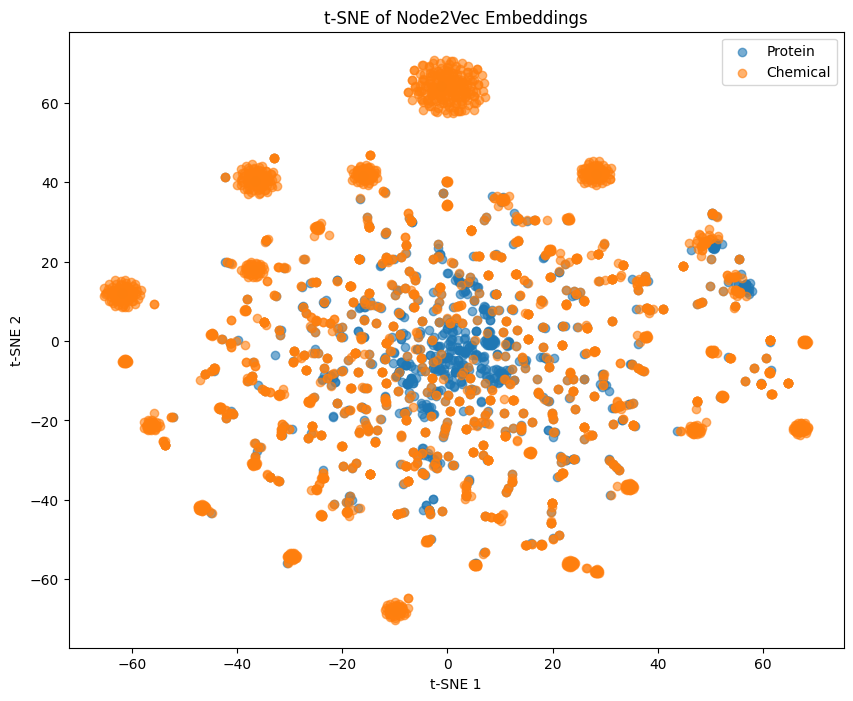

In [14]:
# Assign labels based on prefix (example: "CHEM_" and "PROT_")
labels = ['Chemical' if node.startswith('CID') else 'Protein' for node in nodes]

# Plot
plt.figure(figsize=(10, 8))
for label in set(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=label, alpha=0.6)
plt.legend()
plt.title("t-SNE of Node2Vec Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [22]:

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_2d_umap = reducer.fit_transform(X)

# Repeat the plotting as above using X_2d_umap

/Users/agrawal/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


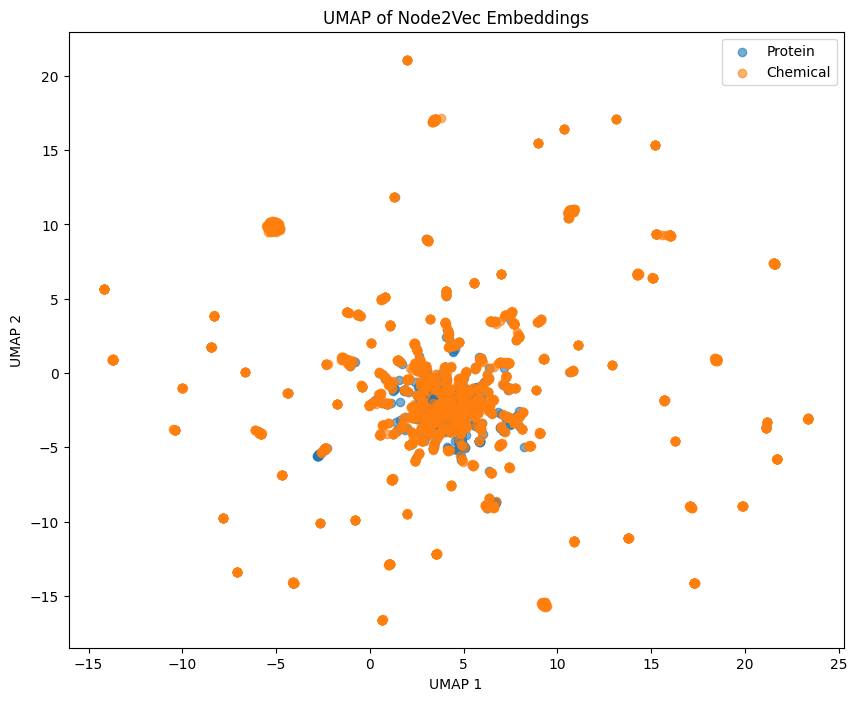

In [16]:
# Plot
plt.figure(figsize=(10, 8))
for label in set(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_2d_umap[idx, 0], X_2d_umap[idx, 1], label=label, alpha=0.6)
plt.legend()
plt.title("UMAP of Node2Vec Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()